# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.10.1


# Загружаем разметку

In [2]:
import os
import json
from glob import glob

TRAIN_PREFIX = 'data/train'

def load_annotations():
    boxes = dict()
    for path in glob('data/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [3]:
boxes = load_annotations()  # загружаем разметку детекций

In [4]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,alb,1719
1,bet,200
2,dol,117
3,lag,67
4,shark,176
5,yft,734


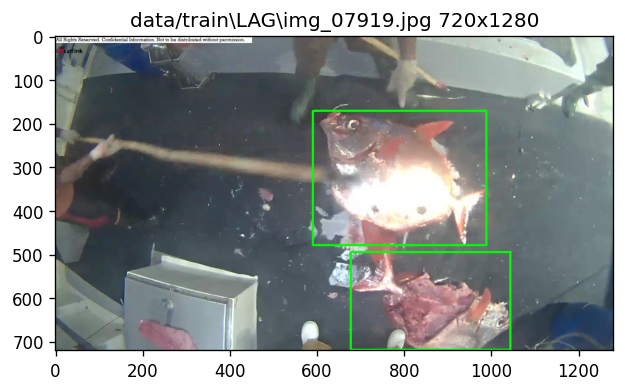

In [5]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

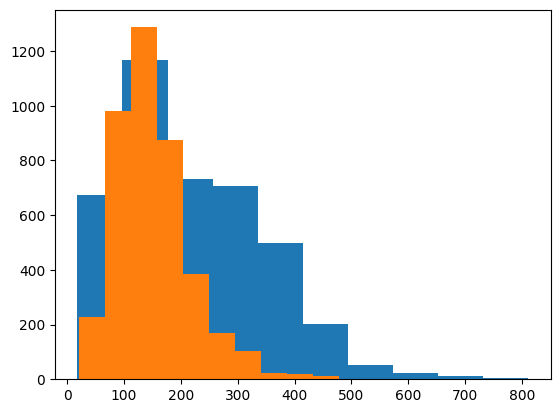

In [6]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [7]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = InceptionResNetV2(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

features.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 750, 1200,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 374, 599, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 374, 599, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

 conv2d_7 (Conv2D)              (None, 91, 147, 64)  76800       ['activation_6[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 91, 147, 96)  82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 91, 147, 64)  12288       ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 91, 147, 96)  288        ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 91, 147, 64)  192        ['conv2d_7[0][0]']               
 rmalizati

 block35_1_ac (Activation)      (None, 91, 147, 320  0           ['block35_1[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 91, 147, 32)  10240       ['block35_1_ac[0][0]']           
                                                                                                  
 batch_normalization_21 (BatchN  (None, 91, 147, 32)  96         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_21 (Activation)     (None, 91, 147, 32)  0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19

 conv2d_29 (Conv2D)             (None, 91, 147, 64)  27648       ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_24 (BatchN  (None, 91, 147, 32)  96         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_26 (BatchN  (None, 91, 147, 32)  96         ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_29 (BatchN  (None, 91, 147, 64)  192        ['conv2d_29[0][0]']              
 ormalization)                                                                                    
          

                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 91, 147, 32)  10240       ['block35_4_ac[0][0]']           
                                                                                                  
 batch_normalization_39 (BatchN  (None, 91, 147, 32)  96         ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_39 (Activation)     (None, 91, 147, 32)  0           ['batch_normalization_39[0][0]'] 
                                                                                                  
 conv2d_37 (Conv2D)             (None, 91, 147, 32)  10240       ['block35_4_ac[0][0]']           
          

                                                                                                  
 batch_normalization_42 (BatchN  (None, 91, 147, 32)  96         ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_44 (BatchN  (None, 91, 147, 32)  96         ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_47 (BatchN  (None, 91, 147, 64)  192        ['conv2d_47[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_57 (Conv2D)             (None, 91, 147, 32)  10240       ['block35_7_ac[0][0]']           
                                                                                                  
 batch_normalization_57 (BatchN  (None, 91, 147, 32)  96         ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_57 (Activation)     (None, 91, 147, 32)  0           ['batch_normalization_57[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 91, 147, 32)  10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_58

 batch_normalization_60 (BatchN  (None, 91, 147, 32)  96         ['conv2d_60[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_62 (BatchN  (None, 91, 147, 32)  96         ['conv2d_62[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_65 (BatchN  (None, 91, 147, 64)  192        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_60 (Activation)     (None, 91, 147, 32)  0           ['batch_normalization_60[0][0]'] 
          

 conv2d_73 (Conv2D)             (None, 91, 147, 256  81920       ['block35_10_ac[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_73 (BatchN  (None, 91, 147, 256  768        ['conv2d_73[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_73 (Activation)     (None, 91, 147, 256  0           ['batch_normalization_73[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 91, 147, 256  589824      ['activation_73[0][0]']          
          

 activation_81 (Activation)     (None, 45, 73, 128)  0           ['batch_normalization_81[0][0]'] 
                                                                                                  
 conv2d_82 (Conv2D)             (None, 45, 73, 160)  143360      ['activation_81[0][0]']          
                                                                                                  
 batch_normalization_82 (BatchN  (None, 45, 73, 160)  480        ['conv2d_82[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_82 (Activation)     (None, 45, 73, 160)  0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 conv2d_80 (Conv2D)             (None, 45, 73, 192)  208896      ['block17_1_ac[0][0]']           
          

                                                                                                  
 batch_normalization_90 (BatchN  (None, 45, 73, 160)  480        ['conv2d_90[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_90 (Activation)     (None, 45, 73, 160)  0           ['batch_normalization_90[0][0]'] 
                                                                                                  
 conv2d_88 (Conv2D)             (None, 45, 73, 192)  208896      ['block17_3_ac[0][0]']           
                                                                                                  
 conv2d_91 (Conv2D)             (None, 45, 73, 192)  215040      ['activation_90[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_98 (Activation)     (None, 45, 73, 160)  0           ['batch_normalization_98[0][0]'] 
                                                                                                  
 conv2d_96 (Conv2D)             (None, 45, 73, 192)  208896      ['block17_5_ac[0][0]']           
                                                                                                  
 conv2d_99 (Conv2D)             (None, 45, 73, 192)  215040      ['activation_98[0][0]']          
                                                                                                  
 batch_normalization_96 (BatchN  (None, 45, 73, 192)  576        ['conv2d_96[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

 conv2d_104 (Conv2D)            (None, 45, 73, 192)  208896      ['block17_7_ac[0][0]']           
                                                                                                  
 conv2d_107 (Conv2D)            (None, 45, 73, 192)  215040      ['activation_106[0][0]']         
                                                                                                  
 batch_normalization_104 (Batch  (None, 45, 73, 192)  576        ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_107 (Batch  (None, 45, 73, 192)  576        ['conv2d_107[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_112 (Batch  (None, 45, 73, 192)  576        ['conv2d_112[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_115 (Batch  (None, 45, 73, 192)  576        ['conv2d_115[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_112 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_112[0][0]']
                                                                                                  
 activation_115 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_115[0][0]']
          

                                                                                                  
 batch_normalization_123 (Batch  (None, 45, 73, 192)  576        ['conv2d_123[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_120 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_120[0][0]']
                                                                                                  
 activation_123 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_123[0][0]']
                                                                                                  
 block17_12_mixed (Concatenate)  (None, 45, 73, 384)  0          ['activation_120[0][0]',         
                                                                  'activation_123[0][0]']         
          

                                                                                                  
 activation_128 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_128[0][0]']
                                                                                                  
 activation_131 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_131[0][0]']
                                                                                                  
 block17_14_mixed (Concatenate)  (None, 45, 73, 384)  0          ['activation_128[0][0]',         
                                                                  'activation_131[0][0]']         
                                                                                                  
 block17_14_conv (Conv2D)       (None, 45, 73, 1088  418880      ['block17_14_mixed[0][0]']       
                                )                                                                 
          

 activation_139 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_139[0][0]']
                                                                                                  
 block17_16_mixed (Concatenate)  (None, 45, 73, 384)  0          ['activation_136[0][0]',         
                                                                  'activation_139[0][0]']         
                                                                                                  
 block17_16_conv (Conv2D)       (None, 45, 73, 1088  418880      ['block17_16_mixed[0][0]']       
                                )                                                                 
                                                                                                  
 block17_16 (Lambda)            (None, 45, 73, 1088  0           ['block17_15_ac[0][0]',          
                                )                                 'block17_16_conv[0][0]']        
          

                                                                  'activation_147[0][0]']         
                                                                                                  
 block17_18_conv (Conv2D)       (None, 45, 73, 1088  418880      ['block17_18_mixed[0][0]']       
                                )                                                                 
                                                                                                  
 block17_18 (Lambda)            (None, 45, 73, 1088  0           ['block17_17_ac[0][0]',          
                                )                                 'block17_18_conv[0][0]']        
                                                                                                  
 block17_18_ac (Activation)     (None, 45, 73, 1088  0           ['block17_18[0][0]']             
                                )                                                                 
          

                                )                                                                 
                                                                                                  
 block17_20 (Lambda)            (None, 45, 73, 1088  0           ['block17_19_ac[0][0]',          
                                )                                 'block17_20_conv[0][0]']        
                                                                                                  
 block17_20_ac (Activation)     (None, 45, 73, 1088  0           ['block17_20[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 45, 73, 256)  278528      ['block17_20_ac[0][0]']          
                                                                                                  
 batch_nor

 batch_normalization_163 (Batch  (None, 22, 36, 192)  576        ['conv2d_163[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_166 (Batch  (None, 22, 36, 256)  768        ['conv2d_166[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_163 (Activation)    (None, 22, 36, 192)  0           ['batch_normalization_163[0][0]']
                                                                                                  
 activation_166 (Activation)    (None, 22, 36, 256)  0           ['batch_normalization_166[0][0]']
                                                                                                  
 block8_1_

 batch_normalization_174 (Batch  (None, 22, 36, 256)  768        ['conv2d_174[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_171 (Activation)    (None, 22, 36, 192)  0           ['batch_normalization_171[0][0]']
                                                                                                  
 activation_174 (Activation)    (None, 22, 36, 256)  0           ['batch_normalization_174[0][0]']
                                                                                                  
 block8_3_mixed (Concatenate)   (None, 22, 36, 448)  0           ['activation_171[0][0]',         
                                                                  'activation_174[0][0]']         
                                                                                                  
 block8_3_

 activation_179 (Activation)    (None, 22, 36, 192)  0           ['batch_normalization_179[0][0]']
                                                                                                  
 activation_182 (Activation)    (None, 22, 36, 256)  0           ['batch_normalization_182[0][0]']
                                                                                                  
 block8_5_mixed (Concatenate)   (None, 22, 36, 448)  0           ['activation_179[0][0]',         
                                                                  'activation_182[0][0]']         
                                                                                                  
 block8_5_conv (Conv2D)         (None, 22, 36, 2080  933920      ['block8_5_mixed[0][0]']         
                                )                                                                 
                                                                                                  
 block8_5 

                                                                                                  
 block8_7_mixed (Concatenate)   (None, 22, 36, 448)  0           ['activation_187[0][0]',         
                                                                  'activation_190[0][0]']         
                                                                                                  
 block8_7_conv (Conv2D)         (None, 22, 36, 2080  933920      ['block8_7_mixed[0][0]']         
                                )                                                                 
                                                                                                  
 block8_7 (Lambda)              (None, 22, 36, 2080  0           ['block8_6_ac[0][0]',            
                                )                                 'block8_7_conv[0][0]']          
                                                                                                  
 block8_7_

                                                                                                  
 block8_9_conv (Conv2D)         (None, 22, 36, 2080  933920      ['block8_9_mixed[0][0]']         
                                )                                                                 
                                                                                                  
 block8_9 (Lambda)              (None, 22, 36, 2080  0           ['block8_8_ac[0][0]',            
                                )                                 'block8_9_conv[0][0]']          
                                                                                                  
 block8_9_ac (Activation)       (None, 22, 36, 2080  0           ['block8_9[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_20

In [8]:
# дообучаем последние 3 слоя
for layer in features.layers[:-4]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 22, 36, 1536)


# Сетка якорей (anchor grid)

In [9]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [10]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh]
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

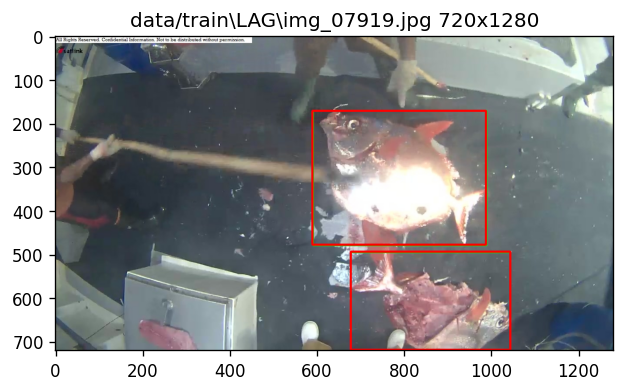

In [11]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [13]:
K = tf.keras.backend

# Заменил conf loss на class loss
def classification_loss(y_true, y_pred):
    class_loss = tf.keras.losses.CategoricalCrossentropy()
    return class_loss(y_true, y_pred)

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))
    
    # classification_loss
    class_loss = classification_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_class_loss = K.sum(class_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_class_loss, _ = tf.nn.top_k(class_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_class_loss = K.sum(neg_class_loss, axis=-1)
    
    # total class loss
    total_class_loss = (neg_class_loss + pos_class_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_class_loss + 0.5 * loc_loss

## Загрузка данных

In [14]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, tf.keras.applications.inception_resnet_v2.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [26]:
for layer in features.layers:
    layer.trainable = False


output = features.layers[-4].output
output = tf.keras.layers.Dense(2080, activation='relu')(output)
output = tf.keras.layers.Dropout(0.4)(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(8,  # один выход (бинарная классификация)
                          activation='softmax')(output) # функция активации

model = tf.keras.Model(inputs=features.inputs, outputs=output, name='fish_detector')
model.summary()

Model: "fish_detector"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 750, 1200,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 374, 599, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 374, 599, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                     

 conv2d_7 (Conv2D)              (None, 91, 147, 64)  76800       ['activation_6[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 91, 147, 96)  82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 91, 147, 64)  12288       ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 91, 147, 96)  288        ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 91, 147, 64)  192        ['conv2d_7[0][0]']               
 rmalizati

 block35_1_ac (Activation)      (None, 91, 147, 320  0           ['block35_1[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 91, 147, 32)  10240       ['block35_1_ac[0][0]']           
                                                                                                  
 batch_normalization_21 (BatchN  (None, 91, 147, 32)  96         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_21 (Activation)     (None, 91, 147, 32)  0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19

 conv2d_29 (Conv2D)             (None, 91, 147, 64)  27648       ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_24 (BatchN  (None, 91, 147, 32)  96         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_26 (BatchN  (None, 91, 147, 32)  96         ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_29 (BatchN  (None, 91, 147, 64)  192        ['conv2d_29[0][0]']              
 ormalization)                                                                                    
          

                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 91, 147, 32)  10240       ['block35_4_ac[0][0]']           
                                                                                                  
 batch_normalization_39 (BatchN  (None, 91, 147, 32)  96         ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_39 (Activation)     (None, 91, 147, 32)  0           ['batch_normalization_39[0][0]'] 
                                                                                                  
 conv2d_37 (Conv2D)             (None, 91, 147, 32)  10240       ['block35_4_ac[0][0]']           
          

                                                                                                  
 batch_normalization_42 (BatchN  (None, 91, 147, 32)  96         ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_44 (BatchN  (None, 91, 147, 32)  96         ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_47 (BatchN  (None, 91, 147, 64)  192        ['conv2d_47[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_57 (Conv2D)             (None, 91, 147, 32)  10240       ['block35_7_ac[0][0]']           
                                                                                                  
 batch_normalization_57 (BatchN  (None, 91, 147, 32)  96         ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_57 (Activation)     (None, 91, 147, 32)  0           ['batch_normalization_57[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 91, 147, 32)  10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_58

 batch_normalization_60 (BatchN  (None, 91, 147, 32)  96         ['conv2d_60[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_62 (BatchN  (None, 91, 147, 32)  96         ['conv2d_62[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_65 (BatchN  (None, 91, 147, 64)  192        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_60 (Activation)     (None, 91, 147, 32)  0           ['batch_normalization_60[0][0]'] 
          

 conv2d_73 (Conv2D)             (None, 91, 147, 256  81920       ['block35_10_ac[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_73 (BatchN  (None, 91, 147, 256  768        ['conv2d_73[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_73 (Activation)     (None, 91, 147, 256  0           ['batch_normalization_73[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 91, 147, 256  589824      ['activation_73[0][0]']          
          

 activation_81 (Activation)     (None, 45, 73, 128)  0           ['batch_normalization_81[0][0]'] 
                                                                                                  
 conv2d_82 (Conv2D)             (None, 45, 73, 160)  143360      ['activation_81[0][0]']          
                                                                                                  
 batch_normalization_82 (BatchN  (None, 45, 73, 160)  480        ['conv2d_82[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_82 (Activation)     (None, 45, 73, 160)  0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 conv2d_80 (Conv2D)             (None, 45, 73, 192)  208896      ['block17_1_ac[0][0]']           
          

                                                                                                  
 batch_normalization_90 (BatchN  (None, 45, 73, 160)  480        ['conv2d_90[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_90 (Activation)     (None, 45, 73, 160)  0           ['batch_normalization_90[0][0]'] 
                                                                                                  
 conv2d_88 (Conv2D)             (None, 45, 73, 192)  208896      ['block17_3_ac[0][0]']           
                                                                                                  
 conv2d_91 (Conv2D)             (None, 45, 73, 192)  215040      ['activation_90[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_98 (Activation)     (None, 45, 73, 160)  0           ['batch_normalization_98[0][0]'] 
                                                                                                  
 conv2d_96 (Conv2D)             (None, 45, 73, 192)  208896      ['block17_5_ac[0][0]']           
                                                                                                  
 conv2d_99 (Conv2D)             (None, 45, 73, 192)  215040      ['activation_98[0][0]']          
                                                                                                  
 batch_normalization_96 (BatchN  (None, 45, 73, 192)  576        ['conv2d_96[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

 conv2d_104 (Conv2D)            (None, 45, 73, 192)  208896      ['block17_7_ac[0][0]']           
                                                                                                  
 conv2d_107 (Conv2D)            (None, 45, 73, 192)  215040      ['activation_106[0][0]']         
                                                                                                  
 batch_normalization_104 (Batch  (None, 45, 73, 192)  576        ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_107 (Batch  (None, 45, 73, 192)  576        ['conv2d_107[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_112 (Batch  (None, 45, 73, 192)  576        ['conv2d_112[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_115 (Batch  (None, 45, 73, 192)  576        ['conv2d_115[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_112 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_112[0][0]']
                                                                                                  
 activation_115 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_115[0][0]']
          

                                                                                                  
 batch_normalization_123 (Batch  (None, 45, 73, 192)  576        ['conv2d_123[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_120 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_120[0][0]']
                                                                                                  
 activation_123 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_123[0][0]']
                                                                                                  
 block17_12_mixed (Concatenate)  (None, 45, 73, 384)  0          ['activation_120[0][0]',         
                                                                  'activation_123[0][0]']         
          

                                                                                                  
 activation_128 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_128[0][0]']
                                                                                                  
 activation_131 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_131[0][0]']
                                                                                                  
 block17_14_mixed (Concatenate)  (None, 45, 73, 384)  0          ['activation_128[0][0]',         
                                                                  'activation_131[0][0]']         
                                                                                                  
 block17_14_conv (Conv2D)       (None, 45, 73, 1088  418880      ['block17_14_mixed[0][0]']       
                                )                                                                 
          

 activation_139 (Activation)    (None, 45, 73, 192)  0           ['batch_normalization_139[0][0]']
                                                                                                  
 block17_16_mixed (Concatenate)  (None, 45, 73, 384)  0          ['activation_136[0][0]',         
                                                                  'activation_139[0][0]']         
                                                                                                  
 block17_16_conv (Conv2D)       (None, 45, 73, 1088  418880      ['block17_16_mixed[0][0]']       
                                )                                                                 
                                                                                                  
 block17_16 (Lambda)            (None, 45, 73, 1088  0           ['block17_15_ac[0][0]',          
                                )                                 'block17_16_conv[0][0]']        
          

                                                                  'activation_147[0][0]']         
                                                                                                  
 block17_18_conv (Conv2D)       (None, 45, 73, 1088  418880      ['block17_18_mixed[0][0]']       
                                )                                                                 
                                                                                                  
 block17_18 (Lambda)            (None, 45, 73, 1088  0           ['block17_17_ac[0][0]',          
                                )                                 'block17_18_conv[0][0]']        
                                                                                                  
 block17_18_ac (Activation)     (None, 45, 73, 1088  0           ['block17_18[0][0]']             
                                )                                                                 
          

                                )                                                                 
                                                                                                  
 block17_20 (Lambda)            (None, 45, 73, 1088  0           ['block17_19_ac[0][0]',          
                                )                                 'block17_20_conv[0][0]']        
                                                                                                  
 block17_20_ac (Activation)     (None, 45, 73, 1088  0           ['block17_20[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 45, 73, 256)  278528      ['block17_20_ac[0][0]']          
                                                                                                  
 batch_nor

 batch_normalization_163 (Batch  (None, 22, 36, 192)  576        ['conv2d_163[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_166 (Batch  (None, 22, 36, 256)  768        ['conv2d_166[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_163 (Activation)    (None, 22, 36, 192)  0           ['batch_normalization_163[0][0]']
                                                                                                  
 activation_166 (Activation)    (None, 22, 36, 256)  0           ['batch_normalization_166[0][0]']
                                                                                                  
 block8_1_

 batch_normalization_174 (Batch  (None, 22, 36, 256)  768        ['conv2d_174[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_171 (Activation)    (None, 22, 36, 192)  0           ['batch_normalization_171[0][0]']
                                                                                                  
 activation_174 (Activation)    (None, 22, 36, 256)  0           ['batch_normalization_174[0][0]']
                                                                                                  
 block8_3_mixed (Concatenate)   (None, 22, 36, 448)  0           ['activation_171[0][0]',         
                                                                  'activation_174[0][0]']         
                                                                                                  
 block8_3_

 activation_179 (Activation)    (None, 22, 36, 192)  0           ['batch_normalization_179[0][0]']
                                                                                                  
 activation_182 (Activation)    (None, 22, 36, 256)  0           ['batch_normalization_182[0][0]']
                                                                                                  
 block8_5_mixed (Concatenate)   (None, 22, 36, 448)  0           ['activation_179[0][0]',         
                                                                  'activation_182[0][0]']         
                                                                                                  
 block8_5_conv (Conv2D)         (None, 22, 36, 2080  933920      ['block8_5_mixed[0][0]']         
                                )                                                                 
                                                                                                  
 block8_5 

                                                                                                  
 block8_7_mixed (Concatenate)   (None, 22, 36, 448)  0           ['activation_187[0][0]',         
                                                                  'activation_190[0][0]']         
                                                                                                  
 block8_7_conv (Conv2D)         (None, 22, 36, 2080  933920      ['block8_7_mixed[0][0]']         
                                )                                                                 
                                                                                                  
 block8_7 (Lambda)              (None, 22, 36, 2080  0           ['block8_6_ac[0][0]',            
                                )                                 'block8_7_conv[0][0]']          
                                                                                                  
 block8_7_

                                                                                                  
 block8_9_conv (Conv2D)         (None, 22, 36, 2080  933920      ['block8_9_mixed[0][0]']         
                                )                                                                 
                                                                                                  
 block8_9 (Lambda)              (None, 22, 36, 2080  0           ['block8_8_ac[0][0]',            
                                )                                 'block8_9_conv[0][0]']          
                                                                                                  
 block8_9_ac (Activation)       (None, 22, 36, 2080  0           ['block8_9[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_20

## Обучение

In [29]:
adam = tf.keras.optimizers.Adam(learning_rate=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[classification_loss])

# <span style="color:red"> Не могу понять где ошибка, хотя суть ее вроде ясна.</span>

In [30]:
batch_size = 32

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=16)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=64,
          callbacks=[checkpoint])

Epoch 1/64


ValueError: in user code:

    File "D:\DataSci\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\voron\AppData\Local\Temp\ipykernel_12664\581910491.py", line 6, in classification_loss  *
        return class_loss(y_true, y_pred)
    File "D:\DataSci\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__  **
        losses = call_fn(y_true, y_pred)
    File "D:\DataSci\anaconda3\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "D:\DataSci\anaconda3\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "D:\DataSci\anaconda3\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None, None, None) and (None, 8) are incompatible


## Результат работы детектора

In [ ]:
# model.load_weights('data/fish/fishdetector_weights.hdf5')

In [ ]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

In [ ]:
test_images = glob('data/fish/test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0